In [1]:
import pandas as pd
import numpy as np
import random

# File operations
from copy import deepcopy
import glob
import os
from pathlib import Path

# Stats
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, wilcoxon, mannwhitneyu, zscore
import statsmodels.stats.multitest

# Neuromaps
import neuromaps
from neuromaps.parcellate import Parcellater
from neuromaps import datasets, images, nulls, resampling, stats
from nibabel import freesurfer as fs
import nibabel as nib
from neuromaps.datasets import fetch_annotation, fetch_fslr

# ENIGMA
from enigmatoolbox.datasets import load_sc, load_fc, load_fc_as_one
from enigmatoolbox.plotting.surface_plotting import plot_subcortical

# Set seed to 127
random.seed(127)

# Add connectome workbench to path
os.environ['PATH'] = os.environ['PATH'] + ':/Applications/workbench/bin_macosx64'

%load_ext rpy2.ipython

objc[8212]: Class QT_ROOT_LEVEL_POOL__THESE_OBJECTS_WILL_BE_RELEASED_WHEN_QAPP_GOES_OUT_OF_SCOPE is implemented in both /Users/abry4213/miniforge3/envs/annie_env/lib/libQt6Core.6.8.2.dylib (0x173e6d6b8) and /Users/abry4213/miniforge3/envs/annie_env/lib/libQt5Core.5.15.15.dylib (0x3137512f8). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[8212]: Class KeyValueObserver is implemented in both /Users/abry4213/miniforge3/envs/annie_env/lib/libQt6Core.6.8.2.dylib (0x173e6d6e0) and /Users/abry4213/miniforge3/envs/annie_env/lib/libQt5Core.5.15.15.dylib (0x313751320). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[8212]: Class RunLoopModeTracker is implemented in both /Users/abry4213/miniforge3/envs/annie_env/lib/libQt6Core.6.8.2.dylib (0x173e6d780) and /Users/abry4213/miniforge3/envs/annie_env/lib/libQt5Core.5.15.15.dylib (0x313751370). This may caus

In [2]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(circlize)
    library(ComplexHeatmap)
    library(cowplot)
    library(dendextend)
    library(FactoMineR)
    library(GGally)
    library(ggseg)
    library(glue)
    library(grid)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

In [22]:
data_path = "/Users/abry4213/github/Homotopic_FC/data/"

#### GROUP-AVERAGED FUNCTIONAL CONNECTOME FROM ENIGMA #### 

# Load cortico-cortical functional connectivity data
fc_ctx, fc_ctx_labels, fc_subctx_to_ctx, fc_subctx_labels = load_fc(parcellation='aparc')

# Load SC--SC functional connectivity data
fc_all, fc_all_labels = load_fc_as_one(parcellation='aparc')

# Find subcortical indices, corresponding to the values in fc_all_labels that don't have a "_"
subctx_indices = np.array([i for i, label in enumerate(fc_all_labels) if "_" not in label])
subctx_labels = fc_all_labels[subctx_indices]
fc_subctx = fc_all[subctx_indices, :][:, subctx_indices]

# Read in preprocessed Pearson-based functional connectivity data from ENIGMA
HCP_ctx_avg_Pearson_FC = (pd.DataFrame(fc_ctx, columns=fc_ctx_labels)
                      .assign(Brain_Region_From = fc_ctx_labels)
                      .melt(id_vars=["Brain_Region_From"], 
                             var_name="Brain_Region_To", 
                             value_name="Mean_Pearson_R")
                      .assign(Base_Region_From = lambda x: x['Brain_Region_From'].str.replace("L_", "").str.replace("R_", ""),
                              Base_Region_To = lambda x: x['Brain_Region_To'].str.replace("L_", "").str.replace("R_", ""),
                              Hemi_From = lambda x: np.where(x['Brain_Region_From'].str.startswith("L_"), "Left", "Right"),
                              Hemi_To = lambda x: np.where(x['Brain_Region_To'].str.startswith("L_"), "Left", "Right"))
)

pearson_homotopic_res_mean = (HCP_ctx_avg_Pearson_FC
                              .query("Base_Region_From == Base_Region_To")
                              .groupby(["Base_Region_From"])['Mean_Pearson_R']
                              .mean() 
                              .reset_index()
                              .rename(columns={"Base_Region_From": "Base_Region"})
                              )

HCP_subctx_avg_Pearson_FC = (pd.DataFrame(fc_subctx, columns=subctx_labels)
                      .assign(Brain_Region_From = subctx_labels)
                      .melt(id_vars=["Brain_Region_From"], 
                             var_name="Brain_Region_To", 
                             value_name="Mean_Pearson_R")
                      # Assign hemisphere based on the letter each region starts with
                      .assign(Hemisphere_From = lambda x: x["Brain_Region_From"].str[0].map({"L": "Left", "R": "Right"}),
                              Hemisphere_To = lambda x: x["Brain_Region_To"].str[0].map({"L": "Left", "R": "Right"}))
                     # Remove first letter from the region names
                            .assign(Base_Region_From = lambda x: x["Brain_Region_From"].str[1:],
                                   Base_Region_To = lambda x: x["Brain_Region_To"].str[1:])
)

HCP_subctx_HoFC = (HCP_subctx_avg_Pearson_FC
                   .query("Base_Region_From == Base_Region_To & Hemisphere_From != Hemisphere_To")
                   .groupby(['Base_Region_From'])['Mean_Pearson_R']
                   .mean() 
                   .reset_index()
                   .rename(columns={"Base_Region_From": "Base_Region",
                                          "Mean_Pearson_R": "Mean_HoFC"})
       )

# Extract Mean_HoFC, repeat 2x, and save to .txt file for plotting in ENIGMA in Matlab
np.concat([HCP_subctx_HoFC["Mean_HoFC"].values, HCP_subctx_HoFC["Mean_HoFC"].values]).tofile(f"{data_path}/HCP_subctx_HoFC.txt", sep="\n")

## What do HoFC magnitudes look like in the subcortex?

In [4]:
HCP_subctx_HoFC['region'] = ['accumbens', 'amygdala', 'caudate', 'hippocampus', 'pallidum', 'putamen', 'thalamus']

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

# Get 12 evenly spaced values from 0 to 1
values = [i / 11 for i in range(12)]  # 11 because range is inclusive at the top

# Get RGB colors from viridis
colors = [cm.plasma(v) for v in values]  # returns RGBA tuples

# If you want HEX codes instead:
from matplotlib.colors import to_hex
hex_colors = [to_hex(c) for c in colors]

subcortical_paths_lookup = pd.read_csv("/Users/abry4213/Downloads/subcortical_paths_lookup.csv")

## How does connectivity to the subcortex relate to cortical HoFC?

In [5]:
subctx_to_ctx_FC = (pd.DataFrame(fc_subctx_to_ctx, columns=fc_ctx_labels)
                          .assign(Brain_Region_From = fc_subctx_labels)
                          .melt(id_vars=["Brain_Region_From"],
                            var_name="Brain_Region_To", 
                            value_name="Mean_Pearson_R")
                            .assign(Hemisphere_From = lambda x: x["Brain_Region_From"].str[0].map({"L": "Left", "R": "Right"}),
                              Hemisphere_To = lambda x: x["Brain_Region_To"].str[0].map({"L": "Left", "R": "Right"}))
                            .assign(Base_Region_From = lambda x: x["Brain_Region_From"].str[1:],
                                    Base_Region_To = lambda x: x.Brain_Region_To.str.replace("L_", "").str.replace("R_", ""))
                            [['Base_Region_From', 'Base_Region_To', 'Mean_Pearson_R']]
                            .rename(columns={"Mean_Pearson_R": "FC_with_subctx",
                                             "Base_Region_From": "Subcortical_Region",
                                             "Base_Region_To": "Cortical_Region"})
                     # Remove first letter from the region names

)

HoFC_with_subctx_connectivity = (pearson_homotopic_res_mean
    .rename(columns={"Base_Region": "Cortical_Region",
                     "Mean_Pearson_R": "HoFC"})
    .merge(subctx_to_ctx_FC, on="Cortical_Region")
    .groupby(['Cortical_Region', 'Subcortical_Region'])[['HoFC', 'FC_with_subctx']]
    .mean()
    .reset_index()
)

HoFC_with_subctx_connectivity.head()

,Cortical_Region,Subcortical_Region,HoFC,FC_with_subctx
0,bankssts,accumb,0.31467,0.016905
1,bankssts,amyg,0.31467,0.098062
2,bankssts,caud,0.31467,0.103207
3,bankssts,hippo,0.31467,0.152820
4,bankssts,pal,0.31467,0.034594


`geom_smooth()` using formula = 'y ~ x'


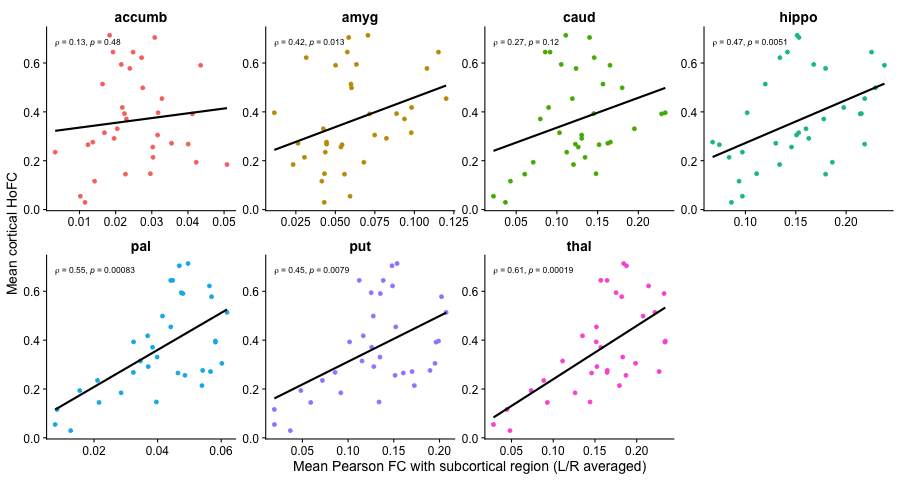

In [6]:
%%R -i HoFC_with_subctx_connectivity -w 900

HoFC_with_subctx_connectivity %>% 
    ggplot(data=., mapping=aes(x=FC_with_subctx, y=HoFC, color=Subcortical_Region)) +
    geom_point() +
    facet_wrap(Subcortical_Region ~ ., scales='free', nrow=2) +
    geom_smooth(method="lm", se=FALSE, color='black') +
    ggpubr::stat_cor(method="spearman", cor.coef.name="rho", size=3, color='black') +
    theme(legend.position='none')+
    ylab("Mean cortical HoFC") +
    xlab("Mean Pearson FC with subcortical region (L/R averaged)") +
    theme(strip.background = element_blank(),
          strip.text = element_text(face='bold', size=14))
# ggsave("../plots/subcortex/Subcortical_FC_vs_homotopic_FC.svg", width=9, height=5, units='in', dpi=300)

In [80]:
all_subctx_pearson_res_with_HoFC = (HCP_subctx_avg_Pearson_FC
 .assign(Connection_Type = lambda x: np.where(x.Base_Region_From == x.Base_Region_To, 'Homotopic', np.where(x.Hemisphere_From==x.Hemisphere_To, 'Intra-hemispheric', 'Inter-hemispheric')))
 .groupby(['Base_Region_From', 'Base_Region_To', 'Connection_Type'])['Mean_Pearson_R']
 .mean()
 .reset_index()
)

# Find the order based on pearson_homotopic_res_mean
region_order_HoFC = HCP_subctx_HoFC.sort_values(by='Mean_HoFC', ascending=True).Base_Region.tolist()

# Make a correlation matrix where the diagonal is values corresponding to Connection_Type=='Homotopic', 
# the lower triangle to Connection_Type=='Intra-hemispheric', and the upper triangle to Connection_Type=='Inter-hemispheric'

# Get unique regions
regions = sorted(set(all_subctx_pearson_res_with_HoFC["Base_Region_From"]).union(set(all_subctx_pearson_res_with_HoFC["Base_Region_To"])))

# Create empty square dataframe
pearson_corr_conn_matrix = pd.DataFrame(np.nan, index=regions, columns=regions)

# Fill matrix based on connection type
for _, row in all_subctx_pearson_res_with_HoFC.iterrows():
    src, tgt, conn_type, value = row["Base_Region_From"], row["Base_Region_To"], row["Connection_Type"], row["Mean_Pearson_R"]
    
    if src == tgt and conn_type == "Homotopic":
        pearson_corr_conn_matrix.loc[src, tgt] = value  # Diagonal
    elif src != tgt:
        # Sort to determine upper/lower placement
        region1, region2 = sorted([src, tgt])

        if conn_type == "Intra-hemispheric":
            pearson_corr_conn_matrix.loc[region2, region1] = value  # Lower triangle
        elif conn_type == "Inter-hemispheric":
            pearson_corr_conn_matrix.loc[region1, region2] = value  # Upper triangle

# Sort the rows and columns based on AHBA_PC1_based_hierarchy_order
pearson_corr_conn_matrix = pearson_corr_conn_matrix.loc[region_order_HoFC, region_order_HoFC]

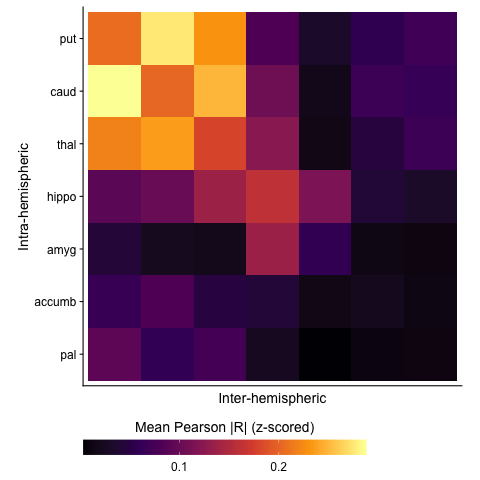

In [94]:
%%R -i pearson_corr_conn_matrix,region_order_HoFC

pearson_corr_conn_matrix %>% 
    mutate(region_1 = rownames(.)) %>%
    pivot_longer(-region_1, names_to="region_2", values_to="Mean_Pearson_R") %>%
    mutate(region_1 = factor(region_1, levels=region_order_HoFC),
           region_2 = factor(region_2, levels=region_order_HoFC)) %>%
    ggplot(data=., mapping=aes(x=region_1, y=region_2, fill=Mean_Pearson_R)) +
    geom_tile() +
    scale_fill_viridis_c(option='inferno') +
    ylab("Intra-hemispheric") +
    xlab("Inter-hemispheric") +
    labs(fill="Mean Pearson |R| (z-scored)") +
    scale_x_discrete(limits=rev) +
    coord_equal() +
    guides(fill=guide_colorbar(title.position="top", title.hjust=0.5)) +
    theme(legend.position='bottom',
          legend.key.width=unit(2, "cm"),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank())
# ggsave("../plots/subcortex/Connection_type_degree_FC_matrix.svg", width=4, height=3.5, units="in", dpi=300)

## Does HoFC correlate with a subcortical region's overall degree?

In [92]:
%%R -i all_subctx_pearson_res_with_HoFC -w 400 -h 300

all_subctx_pearson_res_with_HoFC %>%
    group_by(Base_Region_From) %>% 
    summarise(HoFC_degree = mean(Mean_Pearson_R[Connection_Type == "Homotopic"]),
              Intra_hem_degree = mean(Mean_Pearson_R[Connection_Type == "Intra-hemispheric"]),
              Inter_hem_degree = mean(Mean_Pearson_R[Connection_Type == "Inter-hemispheric"])) %>%
    ungroup() %>%
    pivot_longer(c(Intra_hem_degree, Inter_hem_degree), names_to="Connectivity_Type", values_to="non_HoFC_degree") %>%
    mutate(Connectivity_Type = factor(Connectivity_Type, levels=c("Intra_hem_degree", "Inter_hem_degree"))) %>%
    ggplot(data=., mapping=aes(x=non_HoFC_degree, y=HoFC_degree, fill=HoFC_degree)) +
    geom_point(color='black', shape=21, size=3) +
    scale_fill_viridis_c(option='plasma') +
    xlab("Non-homotopic average FC") +
    ylab("Homotopic FC") +
    geom_smooth(method="lm", se=FALSE, color='black') +
    ggpubr::stat_cor(method="spearman", cor.coef.name="rho", size=5, aes(label = ..r.label..)) +
    facet_wrap(Connectivity_Type ~ ., nrow=1) +
    theme(legend.position='none',
          strip.background = element_blank())

# ggsave("../plots/subcortex/HoFC_vs_other_degree_scatters.svg", width=6, height=3.35, units="in", dpi=300)

`geom_smooth()` using formula = 'y ~ x'


In addition: Warning messages:
1: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 
2: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 
3: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 
4: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping

## Does subcortical HoFC exceed other functional connections within/across hemispheres?

In [93]:
%%R -i all_subctx_pearson_res_with_HoFC

homotopic_subset = all_subctx_pearson_res_with_HoFC %>% filter(Connection_Type == "Homotopic") 
region_order <- homotopic_subset %>% arrange(desc(Mean_Pearson_R)) %>% pull(Base_Region_From)

homotopic_subset <- homotopic_subset %>% 
    mutate(Base_Region_From = factor(Base_Region_From, levels=region_order)) 

all_subctx_pearson_res_with_HoFC <- all_subctx_pearson_res_with_HoFC %>%
    mutate(Base_Region_From = factor(Base_Region_From, levels=region_order)) %>% 
    group_by(Base_Region_From) %>%
    mutate(Homotopic_Fill = mean(Mean_Pearson_R[Connection_Type == "Homotopic"]))

intra_hemispheric_data <- all_subctx_pearson_res_with_HoFC %>% filter(Connection_Type == "Intra-hemispheric")
inter_hemispheric_data <- all_subctx_pearson_res_with_HoFC %>% filter(Connection_Type == "Inter-hemispheric")

ggplot() +
    geom_violinhalf(data=intra_hemispheric_data, 
        aes(x=Base_Region_From, y=Mean_Pearson_R, fill=Homotopic_Fill), scale='width') +
    geom_violinhalf(data=inter_hemispheric_data, 
        aes(x=Base_Region_From, y=Mean_Pearson_R, fill=Homotopic_Fill), flip=TRUE,
        scale='width') +
    stat_summary(data=homotopic_subset, mapping=aes(x=Base_Region_From, y=Mean_Pearson_R),
                 color="black", fun="mean", geom="crossbar", width=1, linewidth=0.3, show.legend=FALSE) +
    scale_fill_viridis_c(option='plasma') +
    scale_y_continuous(expand=c(0,0)) +
    ylab("Mean Pearson FC (z-scored)") +
    xlab("Cortical regions, ordered by HoFC") +
    theme(legend.position='none',
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank())
# ggsave("../plots/subcortex/HoFC_vs_all_other_FC_violins.svg", width=4.5, height=2.5, units="in", dpi=300)